# Single step forecasting with machine learning

[Forecasting with Machine Learning - Course](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook, we will pick up the table of predictive features and a target from the first notebook and train a machine learning model to do forecasting.

We will do **single step** ahead forecasting.

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error

# Load data

We will use the electricity demand dataset found [here](https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec/VIC2015).

**Citation:**

Godahewa, Rakshitha, Bergmeir, Christoph, Webb, Geoff, Hyndman, Rob, & Montero-Manso, Pablo. (2021). Australian Electricity Demand Dataset (Version 1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4659727

**Description of data:**

A description of the data can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html). The data contains electricity demand in Victoria, Australia, at 30 minute intervals over a period of 12 years, from 2002 to early 2015. There is also the temperature in Melbourne at 30 minute intervals and public holiday dates.

In [70]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("h")
    .agg({"demand": "sum"})
)

df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


## Lag features

We shift pass values of the time series forward. We discussed these 3 features in a previous notebook / video.

In [71]:
df[f"y_lag_1"] = df["demand"].shift(periods=1)

freq = "24h"
df[f"y_lag_{freq}"] = df["demand"].shift(freq=freq)

freq = "7d"
df[f"y_lag_{freq}"] = df["demand"].shift(freq=freq)

df.head()

,demand,y_lag_1,y_lag_24h,y_lag_7d
date_time,,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN,NaN
2002-01-01 01:00:00,7165.974188,6919.366092,NaN,NaN
2002-01-01 02:00:00,6406.542994,7165.974188,NaN,NaN
2002-01-01 03:00:00,5815.537828,6406.542994,NaN,NaN
2002-01-01 04:00:00,5497.732922,5815.537828,NaN,NaN


## Window features

We aggregate values within windows in the past.  We discussed these windows in a previous notebook / video.

In [72]:
# We'll use a 3H window size.

result = (
    df["demand"]
    .rolling(window=3) # Pick window size.
    .agg(["mean", "std"]) # Pick statistics.
    .shift(freq="1h") # Lag by 1 hour to avoid data leakage.
)  

result = result.add_prefix("y_window_3_")

# add features to main dataframe

df = df.merge(result, how="left", left_index=True, right_index=True)

df.head()

,demand,y_lag_1,y_lag_24h,y_lag_7d,y_window_3_mean,y_window_3_std
date_time,,,,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN,NaN,NaN,NaN
2002-01-01 01:00:00,7165.974188,6919.366092,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,6406.542994,7165.974188,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,5815.537828,6406.542994,NaN,NaN,6830.627758,387.414253
2002-01-01 04:00:00,5497.732922,5815.537828,NaN,NaN,6462.685003,676.966421


In [73]:
# We'll use a window size of 24 hours to smooth 
# over daily seasonality.

result = (
    df["demand"]
    .rolling(window=24) # Pick window size.
    .agg(["mean", "std"]) # Pick statistics.
    .shift(freq="1h") # Lag by 1 hour to avoid data leakage.
)  

result = result.add_prefix("y_window_24_")

# add features to main dataframe
df = df.merge(result, how="left", left_index=True, right_index=True)

df.head()

,demand,y_lag_1,y_lag_24h,y_lag_7d,y_window_3_mean,y_window_3_std,y_window_24_mean,y_window_24_std
date_time,,,,,,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 01:00:00,7165.974188,6919.366092,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,6406.542994,7165.974188,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,5815.537828,6406.542994,NaN,NaN,6830.627758,387.414253,NaN,NaN
2002-01-01 04:00:00,5497.732922,5815.537828,NaN,NaN,6462.685003,676.966421,NaN,NaN


## Datetime features

We'll create date and time related features from the time series. 

In [74]:
df["month"] = df.index.month
df["day"] = df.index.dayofweek
df["hour"] = df.index.hour

df.head()

,demand,y_lag_1,y_lag_24h,y_lag_7d,y_window_3_mean,y_window_3_std,y_window_24_mean,y_window_24_std,month,day,hour
date_time,,,,,,,,,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0
2002-01-01 01:00:00,7165.974188,6919.366092,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1
2002-01-01 02:00:00,6406.542994,7165.974188,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2
2002-01-01 03:00:00,5815.537828,6406.542994,NaN,NaN,6830.627758,387.414253,NaN,NaN,1,1,3
2002-01-01 04:00:00,5497.732922,5815.537828,NaN,NaN,6462.685003,676.966421,NaN,NaN,1,1,4


## Finalize tabularization

In [75]:
df.dropna(inplace=True)

y = df["demand"]
X = df.drop("demand", axis=1)

# Predictors
X.head()

,y_lag_1,y_lag_24h,y_lag_7d,y_window_3_mean,y_window_3_std,y_window_24_mean,y_window_24_std,month,day,hour
date_time,,,,,,,,,,
2002-01-08 00:00:00,7406.047910,6808.008916,6919.366092,7003.111898,369.947168,7637.818532,865.185351,1,1,0
2002-01-08 01:00:00,7077.081904,7209.285712,7165.974188,7053.973603,364.178734,7649.029907,855.655756,1,1,1
2002-01-08 02:00:00,7445.354310,6535.818342,6406.542994,7309.494708,202.232618,7658.866098,851.728742,1,1,2
2002-01-08 03:00:00,6800.577478,6112.382636,5815.537828,7107.671231,323.474993,7669.897729,838.157008,1,1,3
2002-01-08 04:00:00,6340.914086,6165.882096,5497.732922,6862.281958,554.799634,7679.419873,820.811716,1,1,4


In [76]:
# target

y.head()

date_time
2002-01-08 00:00:00    7077.081904
2002-01-08 01:00:00    7445.354310
2002-01-08 02:00:00    6800.577478
2002-01-08 03:00:00    6340.914086
2002-01-08 04:00:00    6277.978250
Freq: h, Name: demand, dtype: float64

## Lasso

We'll split the data into train and test.

We train the model on the train set and evaluate it on the test set.

In [77]:
# Split into train and test

# We leave 2015 in the test set

end_train = '2014-12-31 23:59:59'

X_train = X.loc[:end_train]
X_test  = X.loc[end_train:]

y_train = y.loc[:end_train]
y_test  = y.loc[end_train:]

In [78]:
lasso = Lasso(random_state=9)

lasso.fit(X_train, y_train)

Lasso(random_state=9)

In [79]:
preds = lasso.predict(X_test)

rmse = root_mean_squared_error(y_test, preds)

print(f"performance of lasso = {np.round(rmse, 0)}")

performance of lasso = 435.0


These results is better than any of the basic forecasts that we did in the previous notebook!

In [80]:
# convert to series for plotting

preds = pd.Series(preds, index=X_test.index)

preds

date_time
2015-01-01 00:00:00     8317.364085
2015-01-01 01:00:00     7424.777158
2015-01-01 02:00:00     6577.107115
2015-01-01 03:00:00     6234.990744
2015-01-01 04:00:00     6292.544796
                           ...     
2015-02-28 19:00:00    10012.257759
2015-02-28 20:00:00     9471.960846
2015-02-28 21:00:00     8634.526915
2015-02-28 22:00:00     8132.633724
2015-02-28 23:00:00     8265.550346
Freq: h, Length: 1416, dtype: float64

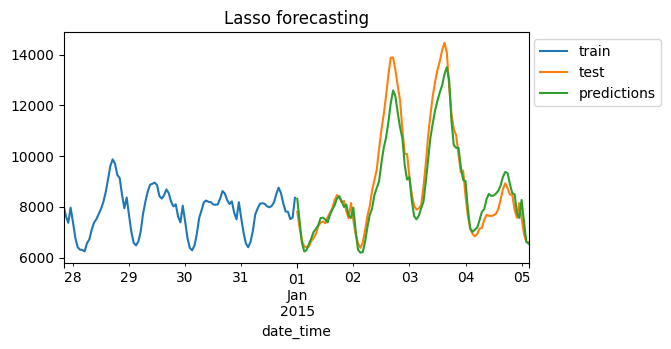

In [81]:
# plot predictions vs actuals

fig, ax = plt.subplots(figsize=(6, 3))
y_train[-100:].plot(ax=ax, label='train')
y_test[:100].plot(ax=ax, label='test')
preds.iloc[:100].plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0))

Text(0, 0.5, 'Coefficient value')

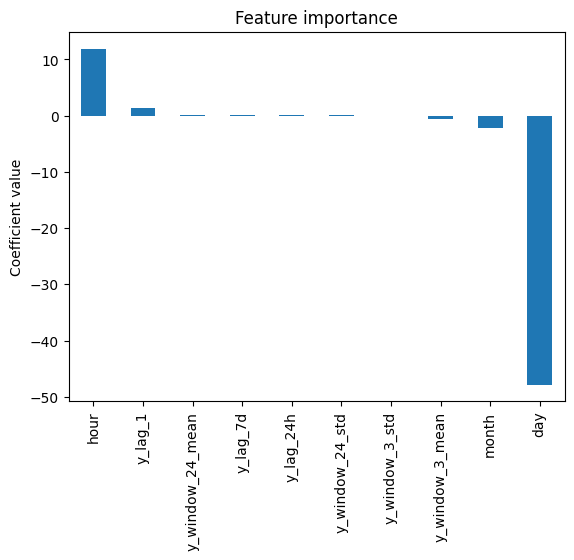

In [82]:
# We can also understand what is driving the predictions of this
# lasso regression.

importance = lasso.coef_
features = lasso.feature_names_in_

pd.Series(importance, index=features).sort_values(ascending=False).plot.bar()
plt.title("Feature importance")
plt.ylabel("Coefficient value")

The hour and the day are the most important predictors of energy consumption.

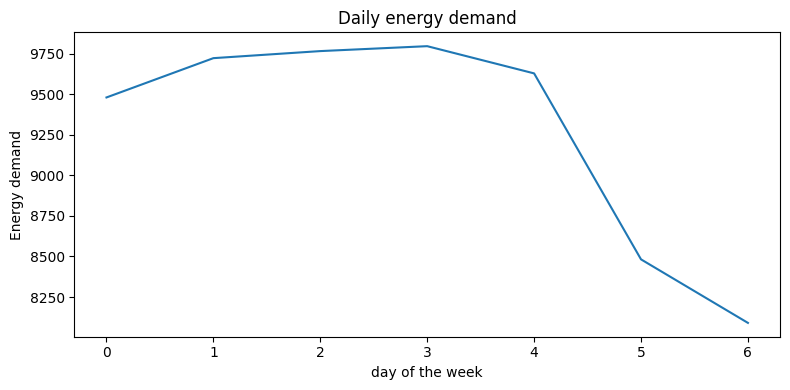

In [83]:
y.groupby(X["day"]).mean().plot(figsize=(8,4))

plt.title("Daily energy demand")
plt.ylabel("Energy demand")
plt.xlabel("day of the week")
plt.tight_layout()

## Random forest

In [84]:
rf = RandomForestRegressor(n_estimators=10, random_state=9)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=9)

In [85]:
preds = rf.predict(X_test)

rmse = root_mean_squared_error(y_test, preds)

print(f"performance of random forests = {np.round(rmse, 0)}")

performance of random forests = 192.0


These results are even better than those from Lasso!

In [86]:
# convert to series for plotting

preds = pd.Series(preds, index=X_test.index)

preds

date_time
2015-01-01 00:00:00    8129.311611
2015-01-01 01:00:00    7100.633051
2015-01-01 02:00:00    6609.057762
2015-01-01 03:00:00    6303.550310
2015-01-01 04:00:00    6514.482052
                          ...     
2015-02-28 19:00:00    9821.619171
2015-02-28 20:00:00    9388.901774
2015-02-28 21:00:00    8400.919126
2015-02-28 22:00:00    8006.276315
2015-02-28 23:00:00    8384.898435
Freq: h, Length: 1416, dtype: float64

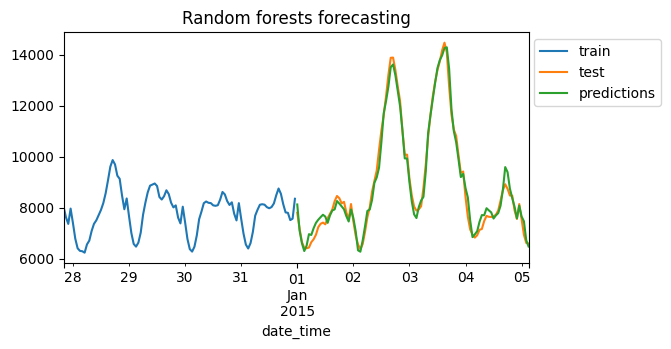

In [87]:
# plot predictions vs actuals

fig, ax = plt.subplots(figsize=(6, 3))
y_train[-100:].plot(ax=ax, label='train')
y_test[:100].plot(ax=ax, label='test')
preds.iloc[:100].plot(ax=ax, label='predictions')
plt.title("Random forests forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0));

Text(0, 0.5, 'Feature importance')

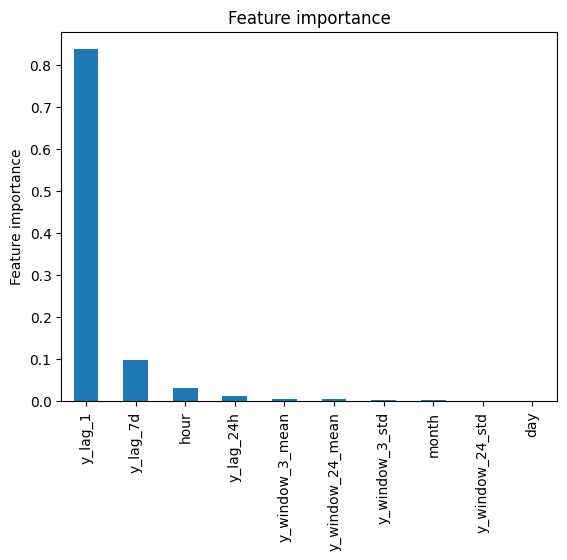

In [88]:
importance = rf.feature_importances_
features = rf.feature_names_in_

pd.Series(importance, index=features).sort_values(ascending=False).plot.bar()
plt.title("Feature importance")
plt.ylabel("Feature importance")

For the random forests, the energy consumption in the previews hour, seems to be the most important feature to predict demand.